**Exploratory Data Analysis**

In [1]:
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor  
from sagemaker.session import Session
import boto3
import sagemaker
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
print('Boto and Sagemaker Sessions Initialized...\nBucket: {0}\nRegion: {1}'.format(bucket, region))
                    
database_name = "foodfacts"                        
raw_table_name = "aai_540_openfoodfacts"           
us_table_name  = "food_us_all"

# Create Athena connection
conn = connect(
    s3_staging_dir=f"s3://{bucket}/athena/staging",
    region_name=region,
    schema_name=database_name
)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Boto and Sagemaker Sessions Initialized...
Bucket: sagemaker-us-east-1-243285667099
Region: us-east-1


In [2]:

conn_pandas = connect(
    s3_staging_dir=f"s3://{bucket}/athena/staging",
    region_name=region,
    schema_name=database_name,
    cursor_class=PandasCursor
)

def q(sql: str) -> pd.DataFrame:
    return pd.read_sql(sql, conn)

In [3]:
## Adjusted section from 01_SetupDatabase with unlimited row  for US region
subset_path = 'food_us_all/'
full_s3_path = f's3://{bucket}/{subset_path}'
statement_ctas = f"""
CREATE TABLE IF NOT EXISTS {database_name}.{us_table_name}
WITH (
  format = 'PARQUET',
  parquet_compression = 'SNAPPY',
  external_location = '{full_s3_path}'
) AS
SELECT
  t.code,
  t.product_name,
  t.nutriments,
  t.nova_group,
  t.additives_n,
  t.ingredients_n,
  t.nutriscore_score
FROM {database_name}.{raw_table_name} AS t
JOIN (
  SELECT DISTINCT
    code,
    murmur3(to_utf8(code)) AS code_hash
  FROM {database_name}.{raw_table_name}
  WHERE contains(countries_tags, 'en:united-states')
    AND nutriscore_score IS NOT NULL 
    AND code IS NOT NULL 
    AND product_name IS NOT NULL 
    AND nova_group IS NOT NULL
    AND additives_n IS NOT NULL
    AND ingredients_n IS NOT NULL
  ORDER BY code_hash, code
) AS unique_codes
ON t.code = unique_codes.code
"""
print(statement_ctas)
_ = q(statement_ctas)

# Row count sanity check
df_count = q(f"SELECT COUNT(*) AS n_rows FROM {database_name}.{us_table_name}")
print(df_count)



CREATE TABLE IF NOT EXISTS foodfacts.food_us_all
WITH (
  format = 'PARQUET',
  parquet_compression = 'SNAPPY',
  external_location = 's3://sagemaker-us-east-1-243285667099/food_us_all/'
) AS
SELECT
  t.code,
  t.product_name,
  t.nutriments,
  t.nova_group,
  t.additives_n,
  t.ingredients_n,
  t.nutriscore_score
FROM foodfacts.aai_540_openfoodfacts AS t
JOIN (
  SELECT DISTINCT
    code,
    murmur3(to_utf8(code)) AS code_hash
  FROM foodfacts.aai_540_openfoodfacts
  WHERE contains(countries_tags, 'en:united-states')
    AND nutriscore_score IS NOT NULL 
    AND code IS NOT NULL 
    AND product_name IS NOT NULL 
    AND nova_group IS NOT NULL
    AND additives_n IS NOT NULL
    AND ingredients_n IS NOT NULL
  ORDER BY code_hash, code
) AS unique_codes
ON t.code = unique_codes.code

   n_rows
0  297865


**BASIC EDA QUERIES**

In [4]:
#  NOVA group counts  
statement_groups = f"""
SELECT CAST(nova_group AS DOUBLE) AS nova_group, COUNT(*) AS cnt
FROM {database_name}.{us_table_name}
GROUP BY 1
ORDER BY cnt DESC
"""
df_groups = q(statement_groups)
display(df_groups)

,nova_group,cnt
0,4.0,201054
1,3.0,59523
2,1.0,31987
3,2.0,5300
4,NaN,1


In [5]:
# Top duplicate product names 
statement_top_products = f"""
SELECT product_name, COUNT(*) AS cnt
FROM {database_name}.{us_table_name}
GROUP BY product_name
ORDER BY cnt DESC
LIMIT 20
"""
df_fr = q(statement_top_products)
print(df_fr)


                                         product_name  cnt
0   [{'lang': 'main', 'text': 'Ice cream'}, {'lang...  581
1   [{'lang': 'main', 'text': 'Soda'}, {'lang': 'e...  457
2   [{'lang': 'main', 'text': 'Ice Cream'}, {'lang...  417
3   [{'lang': 'main', 'text': 'Potato chips'}, {'l...  313
4   [{'lang': 'main', 'text': 'Potato Chips'}, {'l...  268
5   [{'lang': 'main', 'text': 'Extra Virgin Olive ...  268
6   [{'lang': 'main', 'text': 'Popcorn'}, {'lang':...  251
7   [{'lang': 'main', 'text': 'Premium ice cream'}...  239
8   [{'lang': 'main', 'text': 'Cookies'}, {'lang':...  234
9   [{'lang': 'main', 'text': 'Premium Ice Cream'}...  232
10  [{'lang': 'main', 'text': 'Candy'}, {'lang': '...  214
11  [{'lang': 'main', 'text': 'Salsa'}, {'lang': '...  213
12  [{'lang': 'main', 'text': 'Sparkling water'}, ...  172
13  [{'lang': 'main', 'text': 'Creamy Peanut Butte...  160
14                                                 []  158
15  [{'lang': 'main', 'text': 'Cola'}, {'lang': 'e...  1

In [6]:
#Nutri-score “histogram” buckets 
statement_bucket = f"""
WITH bounds AS (
  SELECT MIN(nutriscore_score) AS mn, MAX(nutriscore_score) AS mx
  FROM {database_name}.{us_table_name}
)
SELECT
  width_bucket(nutriscore_score, b.mn, b.mx + 1e-6, 20) AS bucket,  -- CHANGE: +1e-6
  COUNT(*) AS cnt
FROM {database_name}.{us_table_name} f
CROSS JOIN bounds b
GROUP BY 1
ORDER BY 1
"""
df_bucket = q(statement_bucket)
print(df_bucket)

    bucket    cnt
0      1.0    395
1      2.0   1047
2      3.0   2244
3      4.0  15387
4      5.0  41297
5      6.0  29309
6      7.0  28267
7      8.0  19873
8      9.0  41947
9     10.0  42186
10    11.0  25875
11    12.0  22433
12    13.0  10986
13    14.0  12194
14    15.0   3564
15    16.0    581
16    17.0    157
17    18.0     54
18    19.0     55
19    20.0     12
20     NaN      2


**Visuals**

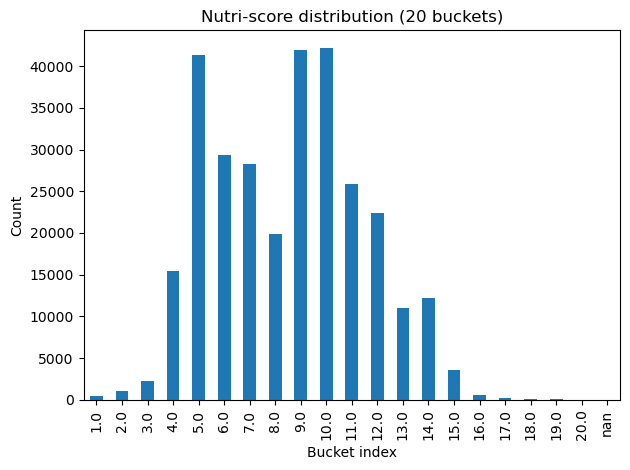

In [7]:
#  Nutri-score bucket bars
ax = df_bucket.plot(kind="bar", x="bucket", y="cnt", legend=False)
ax.set_title("Nutri-score distribution (20 buckets)")
ax.set_xlabel("Bucket index")
ax.set_ylabel("Count")
plt.tight_layout(); plt.show()

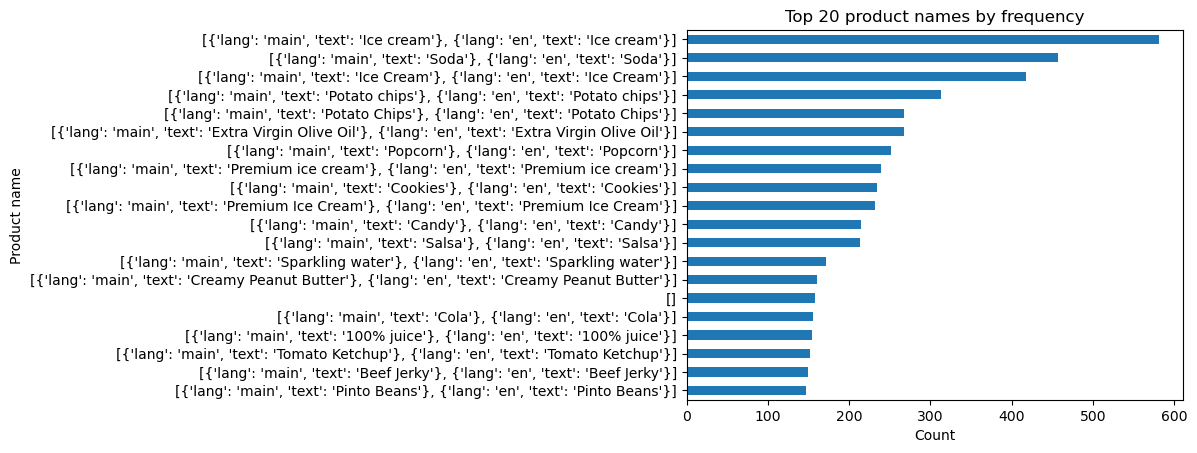

In [8]:
## Top product names 
df_top = df_fr  

ax = df_top.sort_values("cnt").plot(kind="barh", x="product_name", y="cnt", legend=False)
ax.set_title("Top 20 product names by frequency")
ax.set_xlabel("Count")
ax.set_ylabel("Product name")
plt.tight_layout()
plt.show()

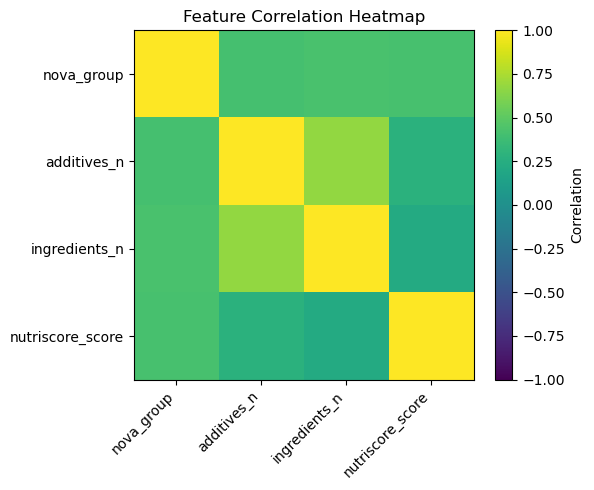

In [9]:
#Correlation  

df_num = q(f"""
SELECT
  CAST(nova_group       AS DOUBLE) AS nova_group,
  CAST(additives_n      AS DOUBLE) AS additives_n,
  CAST(ingredients_n    AS DOUBLE) AS ingredients_n,
  CAST(nutriscore_score AS DOUBLE) AS nutriscore_score
FROM {database_name}.{us_table_name}
""")

corr_cols = ["nova_group", "additives_n", "ingredients_n", "nutriscore_score"]
corr = df_num[corr_cols].corr(numeric_only=True)

plt.figure(figsize=(6,5))
im = plt.imshow(corr.values, vmin=-1, vmax=1, aspect='auto')
plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha='right')
plt.yticks(range(len(corr_cols)), corr_cols)
plt.title("Feature Correlation Heatmap")
cbar = plt.colorbar(im); cbar.set_label("Correlation")
plt.tight_layout(); plt.show()

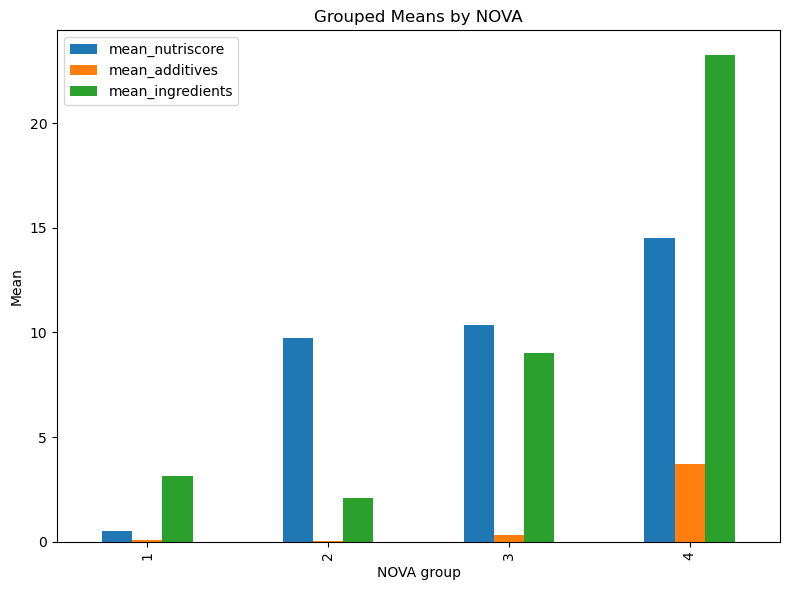

In [10]:
#group Stats 
df_target_mean = q(f"""
  SELECT CAST(nova_group AS INTEGER) AS nova_group, 
         AVG(CAST(nutriscore_score AS DOUBLE)) AS mean_nutriscore,
         AVG(CAST(additives_n      AS DOUBLE)) AS mean_additives,
         AVG(CAST(ingredients_n    AS DOUBLE)) AS mean_ingredients
  FROM {database_name}.{us_table_name}
  WHERE nova_group IS NOT NULL AND nutriscore_score IS NOT NULL
  GROUP BY 1
  ORDER BY 1
""")

ax = df_target_mean.plot(
    x="nova_group",
    y=["mean_nutriscore","mean_additives","mean_ingredients"],
    kind="bar", figsize=(8,6)
)
ax.set_title("Grouped Means by NOVA")
ax.set_xlabel("NOVA group")
ax.set_ylabel("Mean")
plt.tight_layout(); plt.show()

In [12]:
#  Boxplot of Nutri-score by NOVA on a small random sample for speed
df_sample = _conn_vis.cursor().execute(f"""
SELECT nova_group, nutriscore_score
FROM {_database}.{_table}
WHERE nova_group IS NOT NULL AND nutriscore_score IS NOT NULL
ORDER BY rand()
LIMIT 50000
""").as_pandas()

plt.figure()
df_sample.boxplot(column="nutriscore_score", by="nova_group")
plt.title("Nutri-score by NOVA group (random 50k sample)")
plt.suptitle("")  # remove pandas default super-title
plt.xlabel("NOVA group")
plt.ylabel("Nutri-score")
plt.tight_layout()
plt.show()



╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│    1 #  Boxplot of Nutri-score by NOVA on a small random sample for speed                        │
│ ❱  2 df_sample = _conn_vis.cursor().execute(f"""                                                 │
│    3 SELECT nova_group, nutriscore_score                                                         │
│    4 FROM {_database}.{_table}                                                                   │
│    5 WHERE nova_group IS NOT NULL AND nutriscore_score IS NOT NULL                               │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name '_conn_vis' is not defined